In [1]:
import sys
sys.path.append('../src/')

import numpy as np
import pandas as pd
from scipy import sparse as sp
from tqdm.notebook import tqdm
import json

from utils import (
    ProductEncoder,
    make_coo_row,
    normalized_average_precision,
    get_shard_path
)


In [2]:
products = pd.read_csv('/media/dzhumakaev-tk/Storage/Data/retailhero-uplift-data/products.csv')

In [3]:
product_encoder = ProductEncoder("/media/dzhumakaev-tk/Storage/Data/retailhero-uplift-data/products.csv")

## Products Features

In [4]:
products.head()

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [5]:
products.product_id.nunique()

43038

In [6]:
products.level_1.nunique()

3

In [7]:
products.level_2.nunique()

42

In [8]:
products.level_3.nunique()

201

In [9]:
products.level_4.nunique()

790

In [10]:
products.segment_id.nunique()

116

In [11]:
products.brand_id.nunique()

4296

In [12]:
products.vendor_id.nunique()

3193

In [13]:
products_to_extend = products.copy()

In [14]:
products_to_extend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43038 entries, 0 to 43037
Data columns (total 11 columns):
product_id          43038 non-null object
level_1             43035 non-null object
level_2             43035 non-null object
level_3             43035 non-null object
level_4             43035 non-null object
segment_id          41466 non-null float64
brand_id            37838 non-null object
vendor_id           43004 non-null object
netto               43035 non-null float64
is_own_trademark    43038 non-null int64
is_alcohol          43038 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 3.6+ MB


In [15]:
l1_dummies = pd.get_dummies(products_to_extend.level_1, prefix='l1')

In [16]:
l2_dummies = pd.get_dummies(products_to_extend.level_2, prefix='l2')

In [17]:
l3_dummies = pd.get_dummies(products_to_extend.level_3, prefix='l3')

In [18]:
l4_dummies = pd.get_dummies(products_to_extend.level_4, prefix='l4')

In [19]:
seg_dummies = pd.get_dummies(products_to_extend.segment_id, prefix='seg')

In [20]:
brand_dummies = pd.get_dummies(products_to_extend.brand_id, prefix='brand')

In [21]:
vendor_dummies = pd.get_dummies(products_to_extend.vendor_id, prefix='vendor')

In [22]:
products_to_extend['product_idx'] = products_to_extend.product_id.map(product_encoder.toIdx)
products_to_extend.drop('product_id', axis=1, inplace=True)

In [23]:
all(products_to_extend.index == products_to_extend.product_idx)

True

In [24]:
products_to_extend.loc[products_to_extend.netto >= 10,'netto'] = 10
products_to_extend.netto.fillna(np.mean(products_to_extend.netto), inplace=True)

In [25]:
products.is_own_trademark.value_counts()

0    41524
1     1514
Name: is_own_trademark, dtype: int64

In [26]:
products.is_alcohol.value_counts()

0    40645
1     2393
Name: is_alcohol, dtype: int64

In [27]:
products_dummies = pd.concat([l1_dummies, l2_dummies, l3_dummies, l4_dummies, seg_dummies,\
                              brand_dummies, vendor_dummies], axis=1)

In [28]:
products_features = pd.concat([products_to_extend[['product_idx', 'netto', 'is_own_trademark', 'is_alcohol']],\
                               products_dummies], axis=1)
del products_dummies

In [29]:
products_features = products_features.set_index('product_idx')

In [30]:
products_features.head()

,netto,is_own_trademark,is_alcohol,l1_c3d3a8e8c6,l1_e344ab2e71,l1_ec62ce61e3,l2_034aca0659,l2_14d373dff5,l2_15e7af62dd,l2_1d2939ba1d,...,vendor_fee4eb0261,vendor_feedbdb04c,vendor_ff01642e99,vendor_ff2b8833f1,vendor_ff528c09f4,vendor_ff8e7f139a,vendor_ff98ad8348,vendor_ffb94a814d,vendor_ffd309979c,vendor_fff8b92188
product_idx,,,,,,,,,,,,,,,,,,,,,
0,0.400,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.680,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.500,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.112,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.600,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clients Features

In [31]:
clients = pd.read_csv('/media/dzhumakaev-tk/Storage/Data/retailhero-uplift-data/clients.csv')

In [32]:
clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,000048b7a6,2018-12-15 13:33:11,NaN,68,F
3,000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
4,00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


In [33]:
clients.first_issue_date.max()

'2019-03-15 21:50:56'

In [34]:
clients.first_redeem_date.dropna().max()

'2019-11-20 01:14:10'

In [35]:
clients[clients.first_redeem_date.isnull()].shape

(35469, 5)

In [36]:
clients[clients.age > 99].shape

(1052, 5)

In [37]:
clients[clients.gender.isnull()].shape

(0, 5)

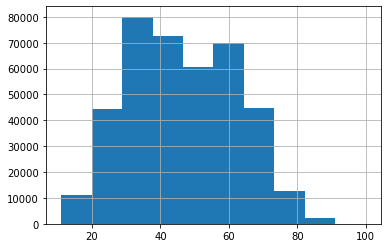

In [38]:
clients[(clients.age > 10) & (clients.age < 101)].age.hist()

In [39]:
clients.gender.value_counts()

U    185706
F    147649
M     66807
Name: gender, dtype: int64

TBD: user features needs to be worked in server

## Main_part

In [40]:
rows = []
for i in range(8):
    for js in tqdm((json.loads(s) for s in open(get_shard_path(i)))):
        rows.append(make_coo_row(js['transaction_history'], product_encoder))
train_mat = sp.vstack(rows)

In [41]:
train_mat.shape

(184516, 43038)

In [42]:
train_mat_extended = sp.vstack([train_mat, products_features.T.values])

In [43]:
train_mat_extended.shape

(193160, 43038)

In [44]:
import implicit

for model, tag in [
    (implicit.nearest_neighbours.TFIDFRecommender(K=30), "tfidf200"),
    (implicit.nearest_neighbours.TFIDFRecommender(K=2), "tfidf2"),
    (implicit.nearest_neighbours.CosineRecommender(K=2), "cosine2"),
    (implicit.nearest_neighbours.CosineRecommender(K=1), "cosine1"),
    (implicit.nearest_neighbours.CosineRecommender(K=2), "cosine2"),
    (implicit.nearest_neighbours.CosineRecommender(K=3), "cosine3"),
    (implicit.nearest_neighbours.CosineRecommender(K=5), "cosine5"),
    (implicit.nearest_neighbours.CosineRecommender(K=10), "cosine10"),
    (implicit.nearest_neighbours.CosineRecommender(K=20), "cosine20"),
    (implicit.nearest_neighbours.CosineRecommender(K=30), "cosine30"),
    (implicit.nearest_neighbours.CosineRecommender(K=50), "cosine50")
    
]:
    scores = []
    model.fit(train_mat.T)
    for js in tqdm((json.loads(s) for s in open(get_shard_path(15)))):

        row = make_coo_row(js['transaction_history'], product_encoder).tocsr()
        raw_recs = model.recommend(userid=0, 
                                   user_items=row, 
                                   N=30, 
                                   filter_already_liked_items=False, 
                                   recalculate_user=True
        )
        recommended_items = product_encoder.toPid([idx for (idx, score) in raw_recs])
        gt_items = js["target"][0]["product_ids"]
        ap = normalized_average_precision(gt_items, recommended_items)
        scores.append(ap)
    mean_ap = np.mean(scores)
    print(tag, mean_ap)


tfidf200 0.10513720334489374



tfidf2 0.12766954425627194



cosine2 0.12972975690063196



cosine1 0.13563339696053237



cosine2 0.12972975690063196



cosine3 0.12816721765704708



cosine5 0.12478903180429073



cosine10 0.12086130064152195



cosine20 0.11746348719952407



cosine30 0.115802542058195



cosine50 0.11488995664027832


In [45]:
import implicit

for model, tag in [
    (implicit.nearest_neighbours.TFIDFRecommender(K=30), "tfidf200"),
    (implicit.nearest_neighbours.TFIDFRecommender(K=2), "tfidf2"),
    (implicit.nearest_neighbours.CosineRecommender(K=2), "cosine2"),
    (implicit.nearest_neighbours.CosineRecommender(K=1), "cosine1"),
    (implicit.nearest_neighbours.CosineRecommender(K=2), "cosine2"),
    (implicit.nearest_neighbours.CosineRecommender(K=3), "cosine3"),
    (implicit.nearest_neighbours.CosineRecommender(K=5), "cosine5"),
    (implicit.nearest_neighbours.CosineRecommender(K=10), "cosine10"),
    (implicit.nearest_neighbours.CosineRecommender(K=20), "cosine20"),
    (implicit.nearest_neighbours.CosineRecommender(K=30), "cosine30"),
    (implicit.nearest_neighbours.CosineRecommender(K=50), "cosine50")
    
]:
    scores = []
    model.fit(train_mat_extended.T)
    for js in tqdm((json.loads(s) for s in open(get_shard_path(15)))):

        row = make_coo_row(js['transaction_history'], product_encoder).tocsr()
        raw_recs = model.recommend(userid=0, 
                                   user_items=row, 
                                   N=30, 
                                   filter_already_liked_items=False, 
                                   recalculate_user=True
        )
        recommended_items = product_encoder.toPid([idx for (idx, score) in raw_recs])
        gt_items = js["target"][0]["product_ids"]
        ap = normalized_average_precision(gt_items, recommended_items)
        scores.append(ap)
    mean_ap = np.mean(scores)
    print(tag, mean_ap)


tfidf200 0.1049197387335745



tfidf2 0.12685943286622287



cosine2 0.11455790794922771



cosine1 0.1345115959436548



cosine2 0.11455790794922771



cosine3 0.10739025991685695



cosine5 0.10075068297591389



cosine10 0.09442417135598109



cosine20 0.09108214033486721



cosine30 0.0888123689225902



cosine50 0.08619031109027253
